In [1]:
import glob, os, sys
sys.path.append("..")
from utils.utils import *
import uproot, ROOT, random, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier 

import shap
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer


Welcome to JupyROOT 6.30/04


/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/ROOT/_facade.py:154: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


In [2]:
###NEW DSIDs

Ztt_inc = [
        700792, 700793, 700794,
        700901, 700902, 700903,
        700360,
        361108
]

ttV = [
    410155, # ttW
    504330, 504334, 504338, 504342, 504346,
    304014, # 3t
]

# Diboson
VV = [
    700488, 700489, 
    700491, 700492, 700493, #700494, 
    700495, #700496,
    700600, 700601, 700602, 700603, 700604, 700605, 
]

# Single-Top and ttbar (new samples now!)
Top = [
    410470, 410471,
    #410472, ##hard coded to skip over this. why?
    410644, 410645, 410646, 410647, 410658, 410659
]

# W(tau/mu/e + nu) + jets
W = [
    700338, 700339, 700340, # Wenu
    700341, 700342, 700343, # Wmunu #! 700342 is missing (should be okay... basically no W)
    700344, 700345, 700346, # WtaunuL
    700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
    700362, 700363, 700364, # W lep + 2jets
]

Zll_inc = [
    700320, 700321, 700322, 
    700467, 700468, 700469, # Zee 
    700323, 700324, 700325, 
    700470, 700471, 700472,# Zmumu
    700358, #Zee2jets
    700359, #Zmumu2jets
]

# Signal samples (new)
ggH = [
    345120, 345121, 345122, 345123,
    345324, #ggHWW  
    600686, #ggZH
    600565, 600566, 600567, 600568 #ggH_He7
    ]
VBFH = [
    346190, 346191, 346192, 346193,
    # 345948, #VBFHWW
    # 600569, 600570, 600571, 600572 #VBFH_He7
]
WH = [345211, 345212,
    #   600573, 600574 #WH_He7
]
ZH = [345217,
    #   600575 #ZH_He7
]
ttH = [346343,346344,346345]

LUMI = {
    '15': 3244.54,
    '16': 33402.2,
    '17': 44630.6,
    '18': 58791.6,    
}

LUMI_SCALE = {
    '15': (3244.54+33402.2)/3244.54,
    '16': (3244.54+33402.2)/33402.2,
    '17': 1,
    '18': 1,
}

In [3]:
# ###OLD DSIDs

# Ztt_inc = [
#     # mc23 DSIDs
#     # 700621, 700622, 700623, 
#     # 700642, 700643, 700644,
#     # 700703, 700704, 700705,
#     # mc20 DSIDs
#     700792, 700793, 700794,
#     700360, # Ztautau2jets
#     ]

# ttV = [
#     410155, # ttW
#     # 410218, 410219, 410220, # ttZs
#     304014, # 3t, 4t #! missing these samples
#     ]

# # Diboson
# VV = [
#     700488, 700489, 
#     700491, 700492, 700493, 700494, 700495, 700496,
#     700600, 700601, 700602, 700603, 700604, 700605, 
# ]

# # Single-Top and ttbar (new samples now!)
# Top = [
#     410470, 410471, 
#     # 410472, 
#     410644, 410645, 410646, 410647, 410658, 410659
# ]

# # W(tau/mu/e + nu) + jets
# W = [
#     700338, 700339, 700340, # Wenu
#     700341, 700342, 700343, # Wmunu #! 700342 is missing (should be okay... basically no W)
#     700344, 700345, 700346, # WtaunuL
#     700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
#     700362, 700363, 700364, # W lep + 2jets
# ]

# Zll_inc = [
#     700320, 700321, 700322, # Zee 
#     700323, 700324, 700325, # Zmumu
#     700358, #Zee2jets
#     700359, #Zmumu2jets
# ]

# # Zee = [
# #     700320, 700321, 700322, # Zee
# #     700358, # Zee2jets
# # ]

# # Zmumu = [
# #     700323, 700324, 700325, # Zmumu
# #     700359, # Zmumu2jetss
# # ]

# # Signal samples (new)
# ggH = [
#     345120, 345121, 345122, 345123
#     ]
# VBFH = [
#     # mc20 DSIDs
#     346190, 346191, 346192, 346193,
# ]
# WH = [345211, 345212]
# ZH = [345217]
# ttH = [346343,346344,346345]

# LUMI = {
#     '15': 3244.54,
#     '16': 33402.2,
#     '17': 44630.6,
#     '18': 58791.6,    
# }

# LUMI_SCALE = {
#     '15': (3244.54+33402.2)/3244.54,
#     '16': (3244.54+33402.2)/33402.2,
#     '17': 1,
#     '18': 1,
# }

In [4]:
# # Combine all lists into one set to get unique numbers
# all_numbers = set(ZttQCD + ZttEWK + ttV + VV + Top + W + Zll_inc + Zee + Zmumu + ggH + VBFH + WH + ZH + ttH + ggHWW + VBFHWW + ggH_He7 + VBFH_He7 + ZH_He7)

# # Count unique numbers
# unique_count = len(all_numbers)
# print("Unique count:", unique_count)

# # Path to the directory
# path = "/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/mc/ditau_hh/mc20e/nom"

# # List all directories in the specified path
# dir_names = os.listdir(path)

# # Extract the "a_number" part from each directory name
# numbers_in_dirs = set()
# for dir_name in dir_names:
#     parts = dir_name.split('.')
#     if len(parts) > 3:
#         a_number = int(parts[4])
#         numbers_in_dirs.add(a_number)

# # Check for matches with all_numbers
# print(len(numbers_in_dirs))
# matches = all_numbers.intersection(numbers_in_dirs)
# non_matches = numbers_in_dirs - all_numbers

# # Print the matches and non-matches
# print("Matching numbers:", matches)
# print("Non-matching numbers:", non_matches)

In [5]:
def read_event_weights(event_id, data_year):
    file_path = './xsec_sumofweights_nom.json'
    # file_path = './xsec_sumofweights_nom_old_V08.json'

    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])

    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        if event_weight is None:
            print(event_id, "weights filled with one")
            results[event_id] = 1
        else: 
            results[event_id] = event_weight / sum_event_weights
    return results


In [6]:
# Define datasets and processes
datasets = ['mc20d', 'mc20a', 'mc20e']
categories = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ZH': ZH, 'ttH': ttH, 
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'ttV': ttV, 'VV': VV, 'Top': Top, 
        'W': W, 'Zll_inc': Zll_inc
    }
}

# Initialize a dictionary to store weights
weights = {}

# Fetch weights for each dataset and category
for dataset in datasets:
    weights[dataset] = {}
    for category, processes in categories.items():
        weights[dataset][category] = {}
        for process_name, process_list in processes.items():
            key = f"{process_name}_ws_{dataset[-1]}"
            weights[dataset][category][key] = fetch_weights(process_list, dataset)

weights

700600 weights filled with one
700601 weights filled with one
700602 weights filled with one
700603 weights filled with one
700604 weights filled with one
700605 weights filled with one
700600 weights filled with one
700601 weights filled with one
700602 weights filled with one
700603 weights filled with one
700604 weights filled with one
700605 weights filled with one
700600 weights filled with one
700601 weights filled with one
700602 weights filled with one
700603 weights filled with one
700604 weights filled with one
700605 weights filled with one


{'mc20d': {'signal': {'VBFH_ws_d': {346190: 3.6361042805246347e-09,
    346191: 1.0190964744828225e-08,
    346192: 1.0228715974527338e-08,
    346193: 1.2459960373122468e-08},
   'ggH_ws_d': {345120: 3.7772811117247e-09,
    345121: 1.4441548725075489e-08,
    345122: 1.443218774025719e-08,
    345123: 5.534380625346609e-09,
    345324: 6.270245333472206e-09,
    600686: 1.0100127099745332e-05,
    600565: 1.2906537292374642e-07,
    600566: 3.306769676287834e-07,
    600567: 1.2408219247061147e-07,
    600568: 4.48156290768772e-08},
   'WH_ws_d': {345211: 2.4693623043284394e-07, 345212: 2.440023027990859e-07},
   'ZH_ws_d': {345217: 1.3553478676015695e-07},
   'ttH_ws_d': {346343: 1.4809819291555298e-07,
    346344: 6.659359232863082e-08,
    346345: 1.60853657449523e-07}},
  'background': {'Ztt_inc_ws_d': {700792: 7.438056333700752e-13,
    700793: 1.0134884723827427e-12,
    700794: 6.667861381856554e-13,
    700901: 1.6006591452064961e-12,
    700902: 1.4718988606024975e-12,
    7

In [7]:
branches = \
[
'ditau_obj_truth_leadTau_p4',
'ditau_obj_truth_subleadTau_p4',
'boson_0_classifierParticleOrigin',
'boson_0_mother_pdgId',
'boson_0_mother_status',
'boson_0_pdgId',
'boson_0_truth_pdgId',
'boson_0_truth_q',
'boson_0_truth_status',
'boson_0_q',
'ditau_obj_IsTruthMatched',
'ditau_obj_IsTruthHadronic',
'ditau_obj_truth_p4',
'met_truth_p4',
'NOMINAL_pileup_random_run_number',
'ditau_obj_bdt_score',
'ditau_obj_omni_score',
'ditau_obj_leadsubjet_charge',
'ditau_obj_leadsubjet_n_core_tracks',
'ditau_obj_leadsubjet_p4',
'ditau_obj_nSubjets',
'ditau_obj_n_tracks',
'ditau_obj_p4',
'ditau_obj_subleadsubjet_charge',
'ditau_obj_subleadsubjet_n_core_tracks',
'ditau_obj_subleadsubjet_p4',
'event_number',
'met_p4',
'met_sumet',
'met_hpto_p4',
'event_is_bad_batman',
'NOMINAL_pileup_combined_weight',
'n_bjets_DL1dv01_FixedCutBEff_70',
'weight_mc']

data_branches = \
[
 'event_number',    
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'ditau_obj_bdt_score',
 'ditau_obj_omni_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_DL1dv01_FixedCutBEff_70']

In [8]:
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/mc/ditau_hh/{year}/nom/user.*.{dsid}.*/user.*.root'
# path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/mc/ditau_hh/{year}/nom/user.shhirose.*{dsid}.*/user.*.root'

def read_root(dsid_list, mc_ws, year_id='mc20e', year='18'):
    out = []
    hlt_branches = {
        '15': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'],
        '16': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'],
        '17': ['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100'],
        '18': ['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    }
    
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid, year=year_id)
        files = glob.glob(file_pattern)
        s = time.time()
        
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                branches_read = branches + hlt_branches.get(year, [])
                events = f_1.arrays(branches_read, library='ak')

                # Handling 2015 and 2016 conditions
                if year in ['15', '16']:
                    mask_15 = (events['NOMINAL_pileup_random_run_number'] <= 284484) & (events['NOMINAL_pileup_random_run_number'] > 0)
                    mask_16 = (events['NOMINAL_pileup_random_run_number'] > 284484) & (events['NOMINAL_pileup_random_run_number'] <= 311563)
                    events['weight'] = mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks']) * events['weight_mc'] * events['NOMINAL_pileup_combined_weight']

                    # Assign weights based on the run number
                    events['weight'] = ak.where(mask_15,
                                                events['weight'] * LUMI_SCALE['15'] * LUMI['15'],
                                                ak.where(mask_16,
                                                         events['weight'] * LUMI_SCALE['16'] * LUMI['16'],
                                                         events['weight']))
                    
                    if not ak.any(mask_15 | mask_16):
                        print(f"Event number out of range in file: {file}")
                elif year in ['17', '18']:
                    events['weight'] = (mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])) * \
                                       events['weight_mc'] * events['NOMINAL_pileup_combined_weight'] * \
                                       LUMI_SCALE[year] * LUMI[year]
                
                out = ak.concatenate((out, events))

        print(f"Processed year: {year}, files for DSID {dsid_list}, Time spent: {round(time.time()-s, 4)} s")
    
    return out


In [9]:
# Year mapping
year_map = {
    'mc20e': '18',
    'mc20d': '17', 
    'mc20a': '15'
}

# Process mapping
processes = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ZH': ZH, 'ttH': ttH
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'ttV': ttV, 'VV': VV, 'Top': Top, 
        'W': W, 'Zll_inc': Zll_inc
    }
}

total_mc = {}
for dataset in ['mc20e', 'mc20d', 'mc20a']:
    suffix = dataset[-1]
    year = year_map[dataset]
    dataset_results = {}
    for category, procs in processes.items():
        for proc_name, proc_list in procs.items():
            weight_key = f"{proc_name}_ws_{suffix}"
            weight = weights[dataset][category][weight_key]
            var_name = f"{proc_name}_{suffix}"
            dataset_results[var_name] = read_root(proc_list, weight, year_id=dataset, year=year)
    total_mc[dataset] = dataset_results

Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.1452 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.1402 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.252 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.2799 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324, 600686, 600565, 600566, 600567, 600568], Time spent: 0.4166 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324, 600686, 600565, 600566, 600567, 600568], Time spent: 0.42 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324, 600686, 600565, 600566, 600567, 600568], Time spent: 0.2828 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324, 600686, 600565, 600566, 600567, 600568], Time spent: 0.3424 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324, 600686, 600565,

In [10]:
## load data
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/data/ditau_hh/data{year}/user.*/user.*.root'
# path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data{year}/user.shhirose.Httbst*/*.root'


def read_data_root(year='18'):
    file_paths = path_template_data.format(year=year)
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        f_1 = uproot.open(l1[i]+':NOMINAL')
        #if file is empty skip
        if f_1.num_entries == 0:
            continue
        branches_read = []
        branches_read.extend(data_branches)
        if year == '15':
            branches_read.extend(['HLT_j360'])
        elif year == '16':
            branches_read.extend(['HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'])
        elif year == '17':
            branches_read.extend(['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100'])
        elif year == '18':
            branches_read.extend(['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111'])
        events = f_1.arrays(branches_read, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1, "time spent", round(time.time()-s, 4), 's')
    return out

data_18 = read_data_root(year='18')
data_17 = read_data_root(year='17')
data_16 = read_data_root(year='16')
data_15 = read_data_root(year='15')

processed:  ['/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/data/ditau_hh/data18/user.ademaria.Htt_01.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6479.n_5_HS/user.ademaria.42100122._000243.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/data/ditau_hh/data18/user.ademaria.Htt_01.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6479.n_5_HS/user.ademaria.42100122._000236.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/data/ditau_hh/data18/user.ademaria.Htt_01.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6479.n_5_HS/user.ademaria.42100122._000355.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/data/ditau_hh/data18/user.ademaria.Htt_01.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6479.n_5_HS/user.ademaria.42100122._000400.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/data/

In [12]:
def save_raw_data(data, data_type='MC'):
    """Process and save raw data before any cuts"""
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    output_file = f'raw_{data_type.lower()}_data.pkl'
    
    # Save data directly
    with open(output_file, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved raw {data_type} data to {output_file}")
    
    return data

save_raw_data(total_mc, 'MC')
save_raw_data({'data_18': data_18, 'data_17': data_17, 
                          'data_16': data_16, 'data_15': data_15}, 'data')


Saved raw MC data to raw_mc_data.pkl
Saved raw data data to raw_data_data.pkl


{'data_18': <Array [{event_number: 1479273893, ...}, ...] type='990075 * {event_number:...'>,
 'data_17': <Array [{event_number: 1098800477, ...}, ...] type='871586 * {event_number:...'>,
 'data_16': <Array [{event_number: 3466734615, ...}, ...] type='424524 * {event_number:...'>,
 'data_15': <Array [{event_number: 37863753, ...}, ...] type='38559 * {event_number: ui...'>}

In [11]:
ditau_id_cut = 0.9

def data_Cut(t, year):
    # Define HLT conditions based on the year
    if year == '15':
        hlt_cut = t['HLT_j360']
    elif year == '16':
        hlt_cut = t['HLT_j380'] | t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100']
    elif year == '17':
        hlt_cut = t['HLT_j400'] | t['HLT_j440_a10_lcw_subjes_L1J100']
    elif year == '18':
        hlt_cut = t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    else:
        raise ValueError(f"Unsupported year: {year}")
    
    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_bdt_score'] < ditau_id_cut) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))

    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]

def mc_Cut(t, year):
    # Define HLT conditions based on the year and run number for 2015 and 2016
    if year == '15' or year == '16':
        mask_15 = (t['NOMINAL_pileup_random_run_number'] <= 284484) & (t['NOMINAL_pileup_random_run_number'] > 0)
        mask_16 = (t['NOMINAL_pileup_random_run_number'] > 284484) & (t['NOMINAL_pileup_random_run_number'] <= 311563)

        hlt_cut_15 = t['HLT_j360']
        hlt_cut_16 = t['HLT_j380'] | t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100']

        hlt_cut = (mask_15 & hlt_cut_15) | (mask_16 & hlt_cut_16)

    elif year == '17':
        hlt_cut = t['HLT_j400'] | t['HLT_j440_a10_lcw_subjes_L1J100']

    elif year == '18':
        hlt_cut = t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    else:
        raise ValueError(f"Unsupported year: {year}")

    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_IsTruthMatched']==1) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_bdt_score'] >= ditau_id_cut) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))

    # Combine HLT-specific cuts with general cuts
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]


In [12]:
def apply_cuts(data, data_type='MC'):
    """
    Apply cuts to both MC and real data
    data_type: 'MC' or 'data'
    """
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    cut_results = {}
    
    if data_type == 'MC':
        year_map = {
        'mc20e': '18',
        'mc20d': '17', 
        'mc20a': '15'
        }
        # Handle MC data structure (nested dictionary)
        for dataset, results in data.items():
            year = year_map[dataset]
            cut_results[dataset] = {}
            
            print(f"Applying MC cuts to {dataset} (year {year})...")
            for var_name, sample in results.items():
                try:
                    cut_results[dataset][var_name] = mc_Cut(sample, year)
                    print(f"Processed {var_name}")
                except Exception as e:
                    print(f"Error processing {var_name}: {str(e)}")
                    cut_results[dataset][var_name] = None
    
    else:
        # Handle real data (direct samples)
        data_vars = {
            'data_18': ('18', data['data_18']),
            'data_17': ('17', data['data_17']),
            'data_16': ('16', data['data_16']),
            'data_15': ('15', data['data_15'])
        }
        
        for name, (year, sample) in data_vars.items():
            print(name, year, sample)
            try:
                cut_results[name] = data_Cut(sample, year)
                print(f"Processed {name}")
            except Exception as e:
                print(f"Error processing {name}: {str(e)}")
                cut_results[name] = None

    return cut_results


In [5]:
with open('raw_mc_data.pkl', 'rb') as f:
    uncut_mc = pickle.load(f)

with open('raw_data_data.pkl', 'rb') as f:
    uncut_data = pickle.load(f)


In [13]:
cut_data = apply_cuts({'data_18': data_18, 'data_17': data_17, 
                       'data_16': data_16, 'data_15': data_15}, data_type='data')
cut_mc = apply_cuts(total_mc, data_type='MC')

data_18 18 [{event_number: 1479273893, met_p4: {fP: {...}, ...}, met_sumet: 862, ...}, ...]
Processed data_18
data_17 17 [{event_number: 1098800477, met_p4: {fP: {...}, ...}, met_sumet: 642, ...}, ...]
Processed data_17
data_16 16 [{event_number: 3466734615, met_p4: {fP: {...}, ...}, met_sumet: 760, ...}, ...]
Processed data_16
data_15 15 [{event_number: 37863753, met_p4: {fP: {...}, ...}, met_sumet: ..., ...}, ...]
Processed data_15
Applying MC cuts to mc20e (year 18)...
Processed VBFH_e
Processed ggH_e
Processed WH_e
Processed ZH_e
Processed ttH_e
Processed Ztt_inc_e
Processed ttV_e
Processed VV_e
Processed Top_e
Processed W_e
Processed Zll_inc_e
Applying MC cuts to mc20d (year 17)...
Processed VBFH_d
Processed ggH_d
Processed WH_d
Processed ZH_d
Processed ttH_d
Processed Ztt_inc_d
Processed ttV_d
Processed VV_d
Processed Top_d
Processed W_d
Processed Zll_inc_d
Applying MC cuts to mc20a (year 15)...
Processed VBFH_a
Processed ggH_a
Processed WH_a
Processed ZH_a
Processed ttH_a
Proces

In [6]:
cut_data = apply_cuts({'data_18': uncut_data['data_18'], 'data_17': uncut_data['data_17'], 
                       'data_16': uncut_data['data_16'], 'data_15': uncut_data['data_15']}, data_type='data')
cut_mc = apply_cuts(uncut_mc, data_type='MC')

data_18 18 [{event_number: 1479273893, met_p4: {fP: {...}, ...}, met_sumet: 862, ...}, ...]
Processed data_18
data_17 17 [{event_number: 1098800477, met_p4: {fP: {...}, ...}, met_sumet: 642, ...}, ...]
Processed data_17
data_16 16 [{event_number: 3466734615, met_p4: {fP: {...}, ...}, met_sumet: 760, ...}, ...]
Processed data_16
data_15 15 [{event_number: 37863753, met_p4: {fP: {...}, ...}, met_sumet: ..., ...}, ...]
Processed data_15
Applying MC cuts to mc20e (year 18)...
Processed VBFH_e
Processed ggH_e
Processed WH_e
Processed ZH_e
Processed ttH_e
Processed Ztt_inc_e
Processed ttV_e
Processed VV_e
Processed Top_e
Processed W_e
Processed Zll_inc_e
Applying MC cuts to mc20d (year 17)...
Processed VBFH_d
Processed ggH_d
Processed WH_d
Processed ZH_d
Processed ttH_d
Processed Ztt_inc_d
Processed ttV_d
Processed VV_d
Processed Top_d
Processed W_d
Processed Zll_inc_d
Applying MC cuts to mc20a (year 15)...
Processed VBFH_a
Processed ggH_a
Processed WH_a
Processed ZH_a
Processed ttH_a
Proces

In [14]:
def combine_mc_years(cut_mc):    
    combined = {}
    # Get base process names (without year suffix)
    base_processes = set()
    for dataset in cut_mc.values():
        for proc in dataset.keys():
            base_name = proc.rsplit('_', 1)[0]  # Remove _e, _d, _a suffix
            base_processes.add(base_name)
    
    # Combine each process across years
    for base_proc in base_processes:
        year_data = []
        for dataset in ['mc20e', 'mc20d', 'mc20a']:
            proc_name = f"{base_proc}_{dataset[-1]}"
            if proc_name in cut_mc[dataset]:
                year_data.append(cut_mc[dataset][proc_name])
        
        # Combine using awkward array concatenation
        if year_data:
            combined[base_proc] = ak.concatenate(year_data)
            print(f"Combined {base_proc} across years")
    
    return combined

def combine_data_years(cut_data):    
    # Extract arrays from all years
    data_arrays = [
        cut_data['data_18'],
        cut_data['data_17'],
        cut_data['data_16'],
        cut_data['data_15']
    ]
    
    # Combine using awkward array concatenation
    combined_data = ak.concatenate(data_arrays)
    print(f"Combined data from all years: {len(combined_data)} events")
    
    return combined_data

In [15]:
combined_mc = combine_mc_years(cut_mc)
combines_data = combine_data_years(cut_data)

Combined VV across years
Combined ttH across years
Combined ZH across years
Combined Top across years
Combined W across years
Combined WH across years
Combined VBFH across years
Combined ttV across years
Combined Zll_inc across years
Combined ggH across years
Combined Ztt_inc across years
Combined data from all years: 201194 events


In [16]:
#combine all mc the samples
vbfh_cut = combined_mc['VBFH']
ggh_cut = combined_mc['ggH']
wh_cut = combined_mc['WH']
zh_cut = combined_mc['ZH']
tth_cut = combined_mc['ttH']
ztt_inc_cut = combined_mc['Ztt_inc']
ttv_cut = combined_mc['ttV']
vv_cut = combined_mc['VV']
top_cut = combined_mc['Top']
w_cut = combined_mc['W']
zll_inc_cut = combined_mc['Zll_inc']

#combine all data samples
data_cut = combines_data


In [17]:
def collinear_mass_calc(k1, k2, metetx, metety):
    k1_px = np.array(k1.px)
    k1_py = np.array(k1.py)
    k1_pz = np.array(k1.pz)
    k1_energy = np.array(k1.energy)
    
    k2_px = np.array(k2.px)
    k2_py = np.array(k2.py)
    k2_pz = np.array(k2.pz)
    k2_energy = np.array(k2.energy)
    
    metetx = np.array(metetx)
    metety = np.array(metety)

    collinear_mass = []
    x1_out = []
    x2_out = []

    for i in range(len(metetx)):
        K = np.array([[k1_px[i], k2_px[i]],
                      [k1_py[i], k2_py[i]]])
        if np.linalg.det(K) == 0:
            print("WARNING: Singular matrix")
            return 0
        M = np.array([[metetx[i]],
                      [metety[i]]])
        
        Kinv = np.linalg.inv(K)
        X = np.dot(Kinv, M)
        X1 = X[0, 0]
        X2 = X[1, 0]
        
        x1 = 1. / (1. + X1)
        x2 = 1. / (1. + X2)
        
        p1 = vector.obj(px=k1_px[i], py=k1_py[i], pz=k1_pz[i], energy=k1_energy[i]) * (1 / x1)
        p2 = vector.obj(px=k2_px[i], py=k2_py[i], pz=k2_pz[i], energy=k2_energy[i]) * (1 / x2)
        
        collinear_mass.append((p1 + p2).mass)
        x1_out.append(x1)
        x2_out.append(x2)
    
    return collinear_mass, x1_out, x2_out


In [18]:
ff_scale = 1

def determine_prong(leadNTracks, subleadNTracks):
    if leadNTracks == 1 and subleadNTracks == 1:
        return 1
    elif leadNTracks == 3 and subleadNTracks == 1:
        return 2
    elif leadNTracks == 1 and subleadNTracks == 3:
        return 2
    elif leadNTracks == 3 and subleadNTracks == 3:
        return 3
    else:
        return -1

def load_histograms(root_file):
    """Load 3D fake factor histograms"""
    file = uproot.open(root_file)
    histograms = {
        "h_ff_1p1p": file["3D_FF_1p1p"].to_hist(),  # Assuming these are the 3D histogram names
        "h_ff_1p3p": file["3D_FF_1p3p"].to_hist(),
        "h_ff_3p3p": file["3D_FF_3p3p"].to_hist()
    }
    return histograms

def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms):
    """Calculate fake factors using 3D histograms with axes: (delta_r, lead_pt, sublead_pt)"""
    weights = []
    
    for lead, sublead, l_pt, s_pt, dr in zip(leadNTracks, subleadNTracks, 
                                            lead_pt, sublead_pt, delta_r):
        prongness = determine_prong(lead, sublead)
        weight = 0
        
        try:
            if prongness == 1:
                hist = histograms["h_ff_1p1p"]
                # Reordered indices to match histogram structure
                delta_r_idx = hist.axes[0].index(dr)
                lead_idx = hist.axes[1].index(l_pt)
                sublead_idx = hist.axes[2].index(s_pt)
                weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
            elif prongness == 2:
                hist = histograms["h_ff_1p3p"]
                delta_r_idx = hist.axes[0].index(dr)
                lead_idx = hist.axes[1].index(l_pt)
                sublead_idx = hist.axes[2].index(s_pt)
                weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
            elif prongness == 3:
                hist = histograms["h_ff_3p3p"]
                delta_r_idx = hist.axes[0].index(dr)
                lead_idx = hist.axes[1].index(l_pt)
                sublead_idx = hist.axes[2].index(s_pt)
                weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
            else:
                print(f"Warning: Invalid prongness value: {prongness}")
                weight = -888
                
        except IndexError:
            print(f"Warning: Value out of histogram bounds: delta_r={dr}, lead_pt={l_pt}, sublead_pt={s_pt}")
            weight = -999

        if weight < 0:
            print(f"Warning: Negative weight: {weight}")
            weight = 1
            
        weights.append(weight)
    
    return [w * ff_scale for w in weights]


In [19]:
# ff_scale = 1

# def determine_prong(leadNTracks, subleadNTracks):
#     if leadNTracks == 1 and subleadNTracks == 1:
#         return 1
#     elif leadNTracks == 3 and subleadNTracks == 1:
#         return 2
#     elif leadNTracks == 1 and subleadNTracks == 3:
#         return 2
#     elif leadNTracks == 3 and subleadNTracks == 3:
#         return 3
#     else:
#         return -1

# def load_histograms(root_file):
#     """Load 3D fake factor histograms"""
#     file = uproot.open(root_file)
#     histograms = {
#         "h_ff_1p1p": file["2D_FF_1p1p"].to_hist(),  # Assuming these are the 3D histogram names
#         "h_ff_1p3p": file["2D_FF_1p3p"].to_hist(),
#         "h_ff_3p3p": file["2D_FF_3p3p"].to_hist()
#     }
#     return histograms

# def fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms):
#     """Calculate fake factors using 3D histograms with axes: (delta_r, lead_pt, sublead_pt)"""
#     weights = []
    
#     for lead, sublead, s_pt, dr in zip(leadNTracks, subleadNTracks, sublead_pt, delta_r):
#         prongness = determine_prong(lead, sublead)
#         weight = 0
        
#         try:
#             if prongness == 1:
#                 hist = histograms["h_ff_1p1p"]
#                 # Reordered indices to match histogram structure
#                 delta_r_idx = hist.axes[0].index(dr)
#                 sublead_idx = hist.axes[1].index(s_pt)
#                 weight = hist.values()[delta_r_idx, sublead_idx]
                
#             elif prongness == 2:
#                 hist = histograms["h_ff_1p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 sublead_idx = hist.axes[1].index(s_pt)
#                 weight = hist.values()[delta_r_idx, sublead_idx]
                
#             elif prongness == 3:
#                 hist = histograms["h_ff_3p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 sublead_idx = hist.axes[1].index(s_pt)
#                 weight = hist.values()[delta_r_idx, sublead_idx]
                
#             else:
#                 print(f"Warning: Invalid prongness value: {prongness}")
#                 weight = -888
                
#         except IndexError:
#             print(f"Warning: Value out of histogram bounds: delta_r={dr}, sublead_pt={s_pt}")
#             weight = -999

#         if weight < 0:
#             print(f"Warning: Negative weight: {weight}")
#             weight = 1
            
#         weights.append(weight)
    
#     return [w * ff_scale for w in weights]


In [20]:
# ff_scale = 1

# def determine_prong(leadNTracks, subleadNTracks):
#     if leadNTracks == 1 and subleadNTracks == 1:
#         return 1
#     elif leadNTracks == 3 and subleadNTracks == 1:
#         return 2
#     elif leadNTracks == 1 and subleadNTracks == 3:
#         return 2
#     elif leadNTracks == 3 and subleadNTracks == 3:
#         return 3
#     else:
#         return -1

# def load_histograms(root_file):
#     file = uproot.open(root_file)
#     histograms = {
#         "h_ff_1p1p": file["FF_1p1p_ditau_obj_subleadsubjet_pt"].to_hist(),
#         "h_ff_1p3p": file["FF_1p3p_ditau_obj_subleadsubjet_pt"].to_hist(),
#         "h_ff_3p3p": file["FF_3p3p_ditau_obj_subleadsubjet_pt"].to_hist()
#     }
#     return histograms

# def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms):
#     weights = []
    
#     for lead, sublead, lead_pt, sublead_pt in zip(leadNTracks, subleadNTracks, lead_pt, sublead_pt):
#         prongness = determine_prong(lead, sublead)
#         weight = 0
        
#         if prongness == 1:
#             bin_idx = histograms["h_ff_1p1p"].axes[0].index(sublead_pt)
#             weight = histograms["h_ff_1p1p"].values()[bin_idx]
#         elif prongness == 2:
#             bin_idx = histograms["h_ff_1p3p"].axes[0].index(sublead_pt)
#             weight = histograms["h_ff_1p3p"].values()[bin_idx]
#         elif prongness == 3:
#             bin_idx = histograms["h_ff_3p3p"].axes[0].index(sublead_pt)
#             weight = histograms["h_ff_3p3p"].values()[bin_idx]
#         else:
#             weight = -1
        
#         weights.append(weight)
    
#     return [w * ff_scale for w in weights]


In [21]:
def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
    # Convert Awkward Arrays to NumPy for calculation
    lead_jet_phi_np = ak.to_numpy(lead_jet_phi)
    sublead_jet_phi_np = ak.to_numpy(sublead_jet_phi)
    met_phi_np = ak.to_numpy(met_phi)
    
    d = np.sin(sublead_jet_phi_np - lead_jet_phi_np)
    centrality = np.full_like(d, -1234.0)
    valid_indices = np.where(d != 0)
    
    A = np.sin(met_phi_np[valid_indices] - lead_jet_phi_np[valid_indices]) / d[valid_indices]
    B = np.sin(sublead_jet_phi_np[valid_indices] - met_phi_np[valid_indices]) / d[valid_indices]
    
    centrality[valid_indices] = (A + B) / np.sqrt(A * A + B * B)
    
    return centrality

In [22]:
def Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                               py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                               pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                               energy=t['ditau_obj_leadsubjet_p4'].fE)
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                                  py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                                  pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                                  energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    event_id = t['event_number']

    combined_weights = t['weight']
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    # met_2d_truth = vector.obj(px=t['met_truth_p4'].fP.fX, py=t['met_truth_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = vector.obj(pt=met_pt, phi=met_phi, eta=0).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
    fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + ditau_p4).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2,
            met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_bdt_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, 
            t.ditau_obj_leadsubjet_n_core_tracks, t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

def Data_Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_leadsubjet_p4'].fE)                           
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
                          
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    # visible_ditau_m = t['ditau_obj_mvis_recalc']  
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass 

    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi

    event_id = t['event_number']
    ######
    histograms = load_histograms("FF_hadhad_ratio_3d_bdt.root")

    leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
    subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
    lead_pt = np.array(leadsubjet_p4.pt)
    sublead_pt = np.array(subleadsubjet_p4.pt)
    delta_r = np.array(delta_R)
    fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms) ###3d
    # fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms) ###2d

    ######
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = vector.obj(pt=met_pt, phi=met_phi, eta=0).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + ditau_p4).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_bdt_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, t.ditau_obj_leadsubjet_n_core_tracks, 
            t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

In [23]:
def cut_x1_x2(t):
    #cut_mask = np.where((np.array(t[6]) > -2.) & (np.array(t[6]) < 2.) & (np.array(t[7]) > -2.) & (np.array(t[7]) < 2.) & (np.array(t[16]) > 0.))[0]
    # cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[6]) < 2.5) & (np.array(t[7]) < 2.5) & (np.array(t[16]) > 0.))[0]
    cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[6]) < 2) & (np.array(t[7]) < 2) & (np.array(t[16]) > 0) & (np.array(t[1]) > 50) & (np.array(t[2]) > 15))[0]
    filtered_t = [np.array(arr)[cut_mask] for arr in t]
    return filtered_t

In [24]:
calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 
             'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead',
             'met_centrality', 'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks', 'e_ratio_lead', 'e_ratio_sublead',
             'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau']


In [25]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)

vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_inc_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_inc_cut)

ggh_plot = cut_x1_x2(ggh_plot)
vbfh_plot = cut_x1_x2(vbfh_plot)
wh_plot = cut_x1_x2(wh_plot)
zh_plot = cut_x1_x2(zh_plot)
tth_plot = cut_x1_x2(tth_plot)

vv_plot = cut_x1_x2(vv_plot)
top_plot = cut_x1_x2(top_plot)
ztt_plot = cut_x1_x2(ztt_plot)
ttv_plot = cut_x1_x2(ttv_plot)
w_plot = cut_x1_x2(w_plot)
zll_plot = cut_x1_x2(zll_plot)

#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)


In [26]:
data_plot = Data_Var(data_cut)
data_plot = cut_x1_x2(data_plot)
data_s = np.array(data_plot).T
data_plot = pd.DataFrame(data_s, columns=calc_vars)
data_plot

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,met,collinear_mass,x1,x2,met_sig,met_phi,...,subleadsubjet_charge,leadsubjet_n_core_tracks,subleadsubjet_n_core_tracks,e_ratio_lead,e_ratio_sublead,higgs_pt,leadsubjet_eta,subleadsubjet_eta,ditau_eta,delta_phi_met_ditau
0,498.001313,365.697781,70.470094,44.083275,39.667834,50.033776,1.370831,0.529717,0.087362,-0.481712,...,-1.0,3.0,3.0,0.705267,0.127899,461.472889,-0.928955,-0.840516,-0.955031,-2.756895
1,453.764313,246.998797,173.872062,197.798362,22.720100,196.509135,0.848922,1.193450,0.032973,1.532269,...,1.0,1.0,3.0,0.616784,0.278878,470.298158,1.049864,0.241435,0.768097,0.772824
2,621.459625,554.211437,23.206027,34.268269,15.448820,66.728132,1.478476,0.122915,0.028236,-0.575181,...,1.0,3.0,1.0,0.873977,0.038318,607.472343,0.099496,0.313172,0.108982,-2.708412
3,486.073813,402.541688,18.290605,29.636746,15.964799,48.274705,1.145400,0.239535,0.031057,0.713481,...,1.0,3.0,1.0,0.796947,0.035434,491.230828,-1.259853,-1.233729,-1.294175,-1.257375
4,345.637969,286.337219,16.777770,66.223234,72.251962,174.508521,1.475441,0.097708,0.151021,3.098572,...,-1.0,3.0,1.0,0.774057,0.089881,403.873528,0.653868,1.531334,0.712998,-0.692914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53414,339.352500,303.348031,16.553873,22.495214,28.317954,24.983579,1.148896,0.591680,0.066006,2.396351,...,-1.0,3.0,1.0,0.904018,0.045880,311.185444,1.970471,1.894644,1.958247,-3.042707
53415,397.798656,350.694031,19.489359,74.141429,62.171662,86.909940,1.251116,0.564524,0.132302,2.230804,...,1.0,3.0,1.0,0.876668,0.049391,337.492640,-1.783427,-1.797972,-1.783723,-2.915776
53416,384.978156,327.999937,26.269869,28.704275,9.640893,26.458057,0.955075,1.304981,0.020846,1.081083,...,-1.0,3.0,3.0,0.834610,0.066474,394.387113,-0.171530,-0.119437,-0.156814,0.222507
53417,334.736188,268.021656,29.381939,60.286042,16.562507,66.081013,1.103701,0.742492,0.039029,0.034375,...,-1.0,3.0,1.0,0.748378,0.106665,319.140772,-0.377499,-0.860165,-0.463220,-2.806605


In [27]:

# import matplotlib.gridspec as gridspec


# # Create figure and gridspec
# fig = plt.figure(figsize=(10, 8))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.1)

# # Calculate histograms
# bins = np.linspace(0, 1, 30)  # Fixed range 0-3
# bin_centers = (bins[:-1] + bins[1:]) / 2

# # Get histogram values
# hist_ff, _ = np.histogram(ff_995, bins=bins, density=True)
# hist_data, _ = np.histogram(data_plot['fake_factor'], bins=bins, density=True)

# # Top plot - Histograms
# ax1 = plt.subplot(gs[0])
# ax1.hist(ff_995, bins=bins, alpha=0.5, label='FF_995', density=True)
# ax1.hist(data_plot['fake_factor'], bins=bins, alpha=0.5, label='FF_99', density=True)
# ax1.legend()
# ax1.set_xlabel('')
# ax1.set_ylabel('Normalized Entries')
# # ax1.set_xlim(0, 3)

# # Bottom plot - Ratio using bin centers
# ax2 = plt.subplot(gs[1])
# ratio = np.divide(hist_ff, hist_data, where=hist_data!=0)  # Avoid division by zero
# ax2.scatter(bin_centers, ratio, alpha=0.5)
# ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
# ax2.set_xlabel('Fake Factor')
# ax2.set_ylabel('FF_995/Data')
# # ax2.set_xlim(0, 3)
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [28]:
# print(data_plot[data_plot['fake_factor'] == -999])
print(data_plot[data_plot['fake_factor'] < 0])

Empty DataFrame
Columns: [ditau_pt, leadsubjet_pt, subleadsubjet_pt, visible_ditau_m, met, collinear_mass, x1, x2, met_sig, met_phi, event_number, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead, met_centrality, omni_score, leadsubjet_charge, subleadsubjet_charge, leadsubjet_n_core_tracks, subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead, higgs_pt, leadsubjet_eta, subleadsubjet_eta, ditau_eta, delta_phi_met_ditau]
Index: []

[0 rows x 37 columns]


In [29]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0

data_plot['label'] = 0

# Add a 'sample_type' column to each DataFrame
vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'

vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

#print how many events of each sample
print('VBFH:', len(vbfh_plot))
print('GGH:', len(ggh_plot))
print('WH:', len(wh_plot))
print('ZH:', len(zh_plot))
print('TTH:', len(tth_plot))
print('VV:', len(vv_plot))
print('TOP:', len(top_plot))
print('ZTT:', len(ztt_plot))
print('TTV:', len(ttv_plot))
print('W:', len(w_plot))
print('ZLL:', len(zll_plot))
print('Data:', len(data_plot))

df = pd.concat([data_plot, ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot])

training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 'met_centrality',
    'event_number', 'fake_factor', 'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 
    'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks',
    'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead',
    'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau'
]

df = df[training_var]

VBFH: 4532
GGH: 5230
WH: 447
ZH: 408
TTH: 215
VV: 18605
TOP: 100
ZTT: 474057
TTV: 362
W: 286
ZLL: 59871
Data: 53419


613872


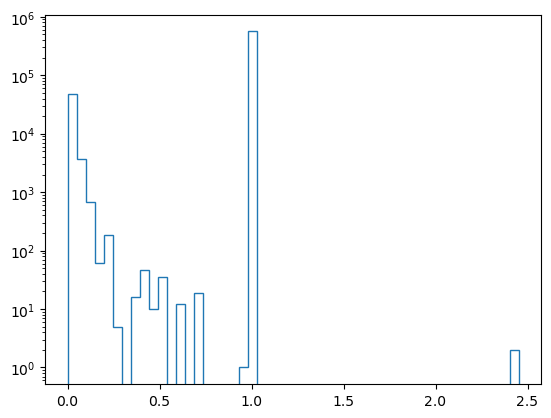

In [21]:
plt.hist(df['fake_factor'], bins=50, histtype='step')
print(len(df['fake_factor']))
plt.yscale('log')
plt.show()

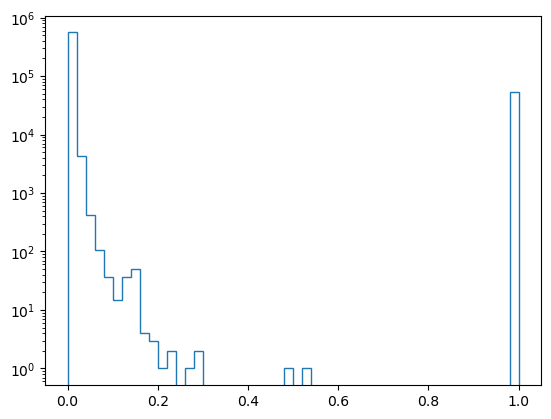

In [22]:
plt.hist(df['combined_weights'], bins=50, histtype='step')
plt.yscale('log')
plt.show()

Signal: 22.921854808666087


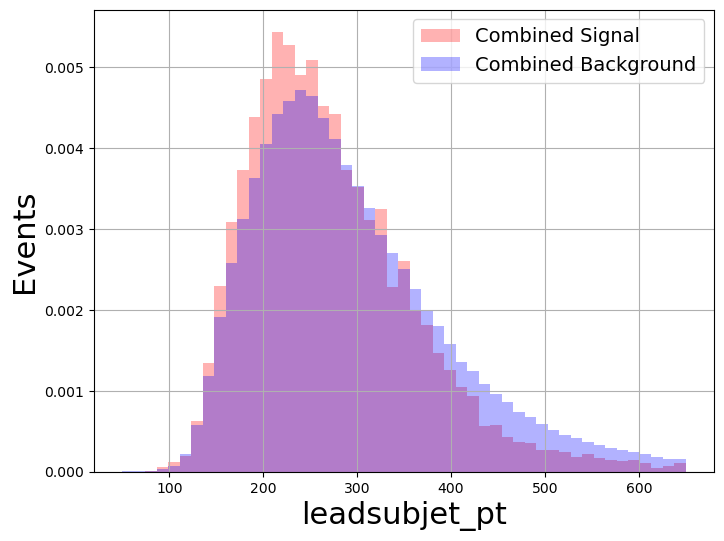

leadsubjet_pt bkg min: 50.1304453125 bkg max: 1964.16375
leadsubjet_pt sig min: 84.0182265625 sig max: 1152.355875
Signal: 17.3118550066398


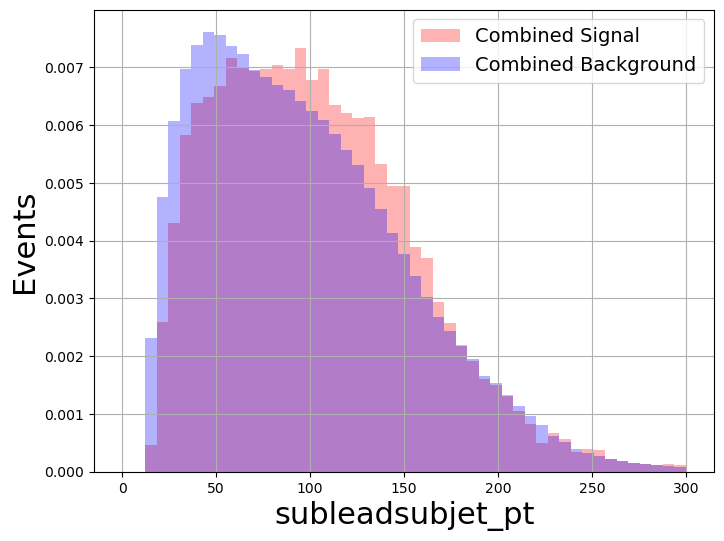

subleadsubjet_pt bkg min: 15.0000029296875 bkg max: 735.5346875
subleadsubjet_pt sig min: 15.102614257812501 sig max: 436.08459375000007
Signal: 29.202442580122177


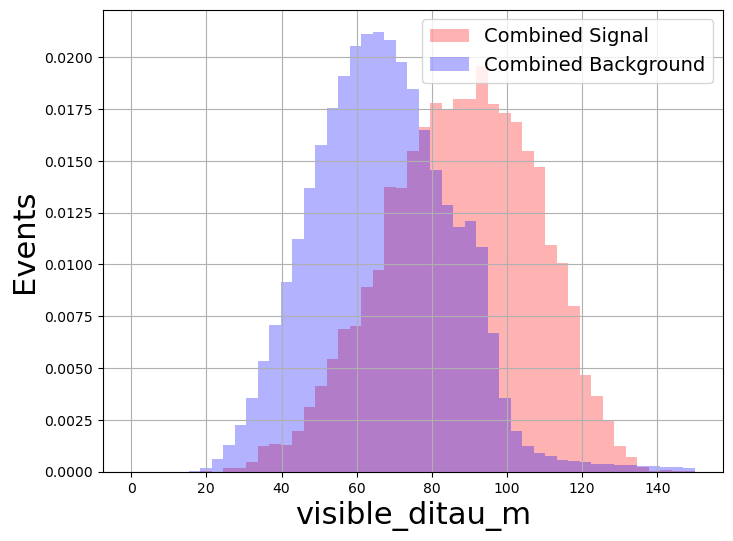

visible_ditau_m bkg min: 13.162152012374063 bkg max: 645.4143173028011
visible_ditau_m sig min: 19.337315538989476 sig max: 191.67820330783584
Signal: 35.859264573502536


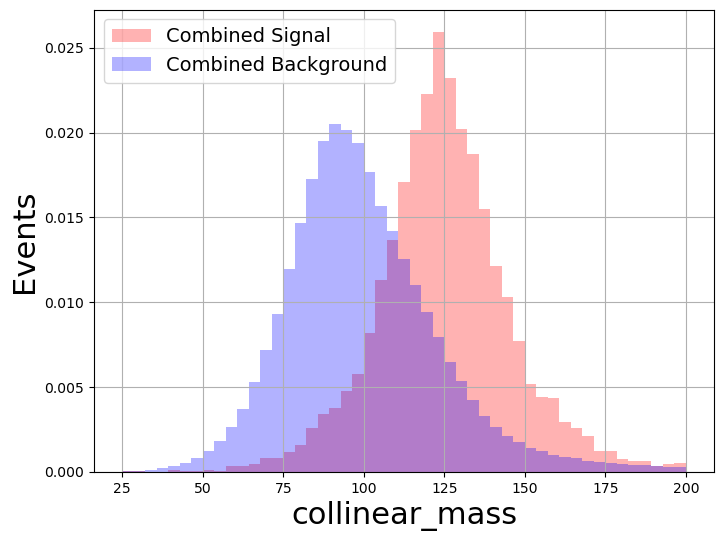

collinear_mass bkg min: 17.487502359347733 bkg max: 998.6466782829499
collinear_mass sig min: 28.387809543728117 sig max: 409.5151949000426
Signal: 35.75034645108313


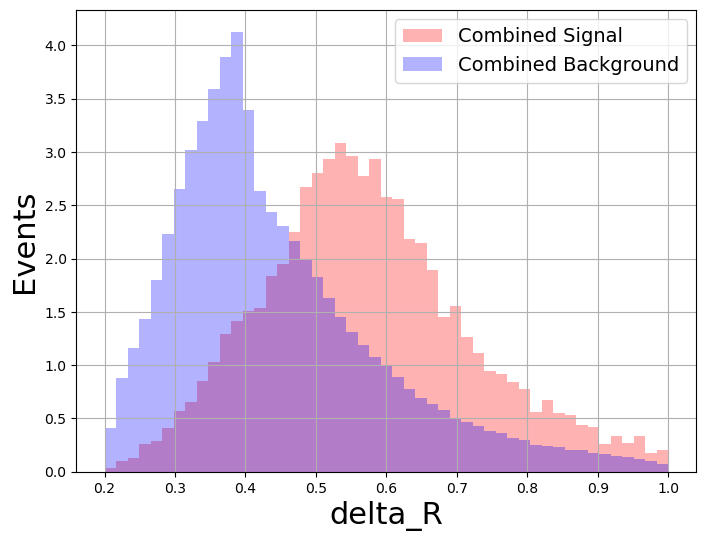

delta_R bkg min: 0.19924480469107037 bkg max: 1.4918923460323457
delta_R sig min: 0.20046786338496647 sig max: 1.0270758691728723
Signal: 14.12808322204227


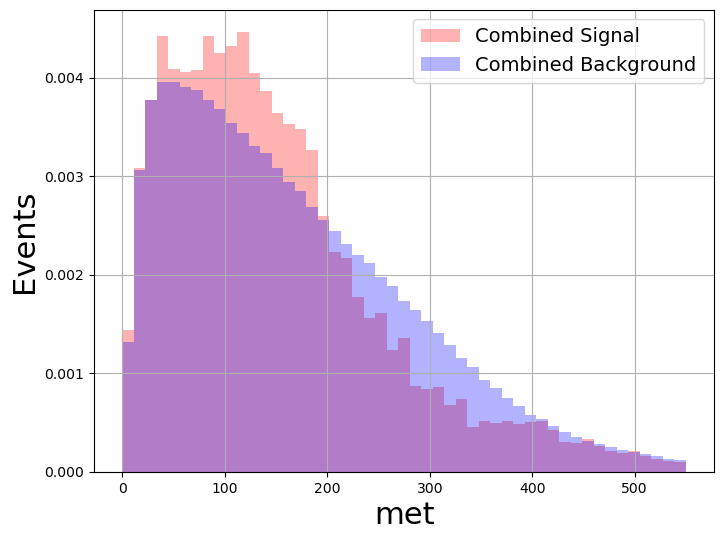

met bkg min: 0.18084062207467225 bkg max: 1814.359302074209
met sig min: 0.9466689444148181 sig max: 1102.3271644964564
Signal: 15.275897705817346


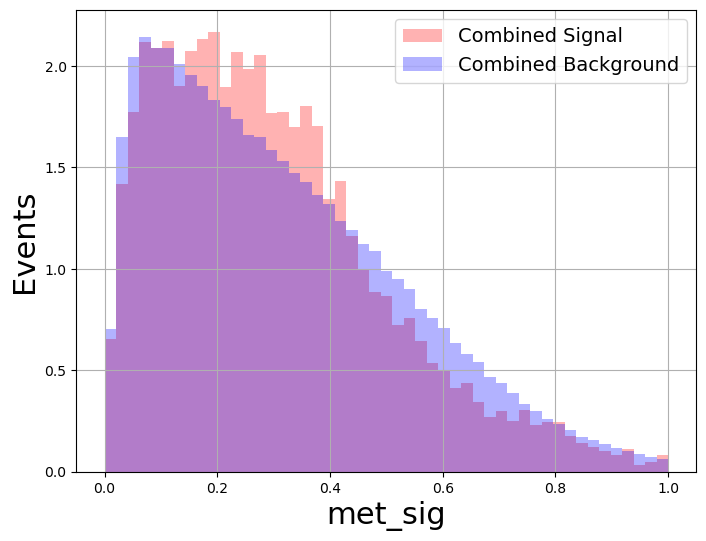

met_sig bkg min: 0.00027835073893821695 bkg max: 2.4687424009726673
met_sig sig min: 0.0016457857452700493 sig max: 1.5438043406227044
Signal: 21.22065421301894


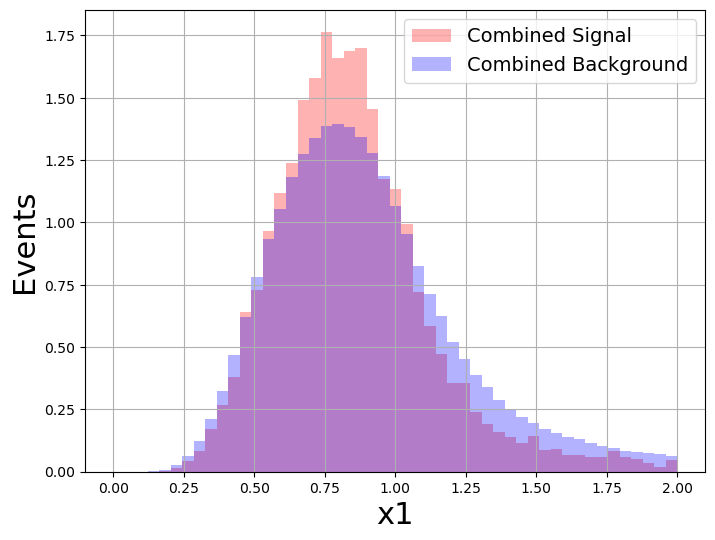

x1 bkg min: 0.09680047346682477 bkg max: 1.999954705114168
x1 sig min: 0.191650215630981 sig max: 1.9996248586480334
Signal: 17.087229743392257


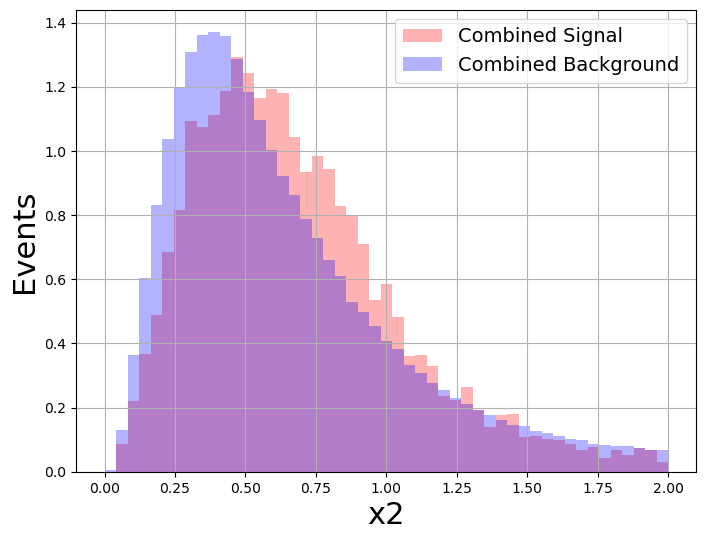

x2 bkg min: 0.016652205218431724 bkg max: 1.9999604851596777
x2 sig min: 0.04339503318954748 sig max: 1.9933797405730431
Signal: 15.915839909769531


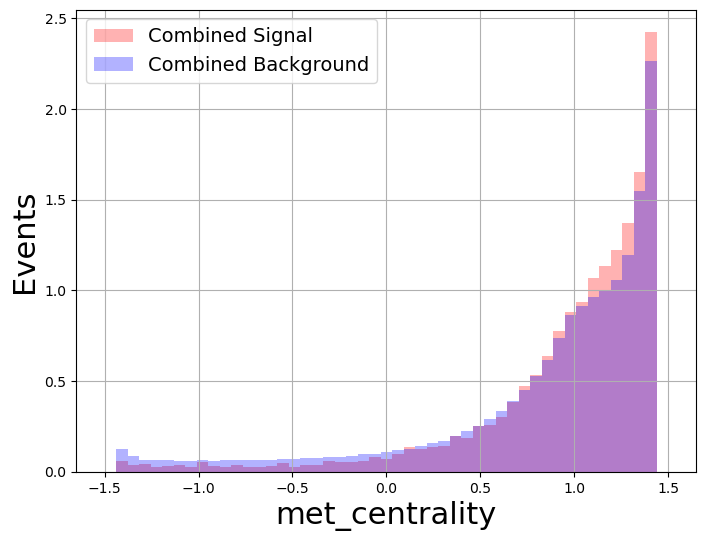

met_centrality bkg min: -1.4142135553276913 bkg max: 1.4142135623658976
met_centrality sig min: -1.4141996324493475 sig max: 1.4142135609881468
Signal: -0.025935758745427896


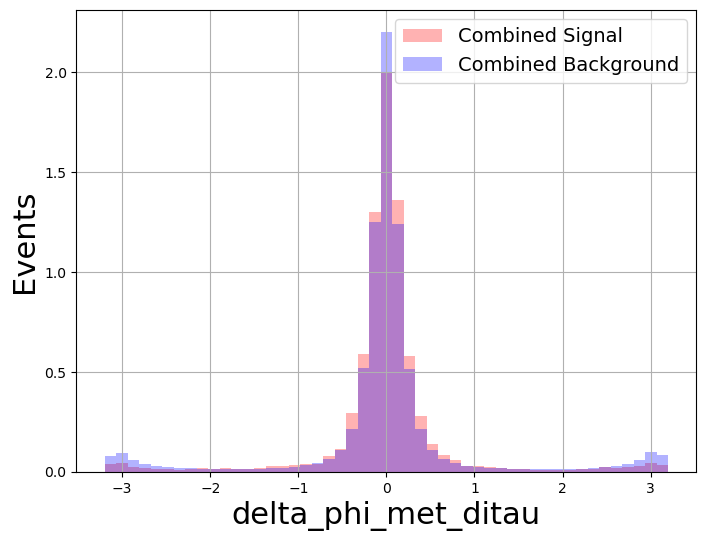

delta_phi_met_ditau bkg min: -3.1415913124150165 bkg max: 3.141564035753591
delta_phi_met_ditau sig min: -3.140970763698399 sig max: 3.1400393195461147


In [29]:
# Define variables and their plotting ranges
plot_configs = {
    'leadsubjet_pt': (50, 650, 50),      # GeV
    'subleadsubjet_pt': (0, 300, 50),   # GeV
    'visible_ditau_m': (0, 150, 50),    # GeV
    'collinear_mass': (25, 200, 50),     # GeV
    'delta_R': (0.2, 1, 50),              # Angular separation
    # 'delta_R_lead': (0.2, 0.9, 50),              # Angular separation
    # 'delta_R_sublead': (0.2, 0.9, 50),              # Angular separation
    'met': (0, 550, 50),                # GeV
    'met_sig': (0, 1, 50),             # MET significance
    'x1': (0, 2, 50),                   # Momentum fraction
    'x2': (0, 2, 50),                   # Momentum fraction
    'met_centrality': (-1.5, 1.5, 50),       # Centrality
    'delta_phi_met_ditau': (-3.2, 3.2, 50)       # Centrality
}

# Signal and background processes
signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
background_processes = [vv_plot, ztt_plot, zll_plot, w_plot, ttv_plot, top_plot]
# background_processes = [zll_plot]


# Create plot for each variable
for var, (xmin, xmax, nbins) in plot_configs.items():
    plt.figure(figsize=(8, 6))
    plt_bins = np.linspace(xmin, xmax, nbins)
    
    # Plot signal
    combined_signal = np.concatenate([process[var] for process in signal_processes])
    plt.hist(combined_signal, bins=plt_bins, histtype='stepfilled', 
             alpha=0.3, label='Combined Signal', color='red', density=True)
    
    # Plot background
    combined_background = np.concatenate([process[var] for process in background_processes])
    plt.hist(combined_background, bins=plt_bins, histtype='stepfilled', 
             alpha=0.3, label='Combined Background', color='blue', density=True)
    
    #print area under curve bin height = bin count / (total count * bin width)
    print('Signal:', np.sum(combined_signal) / (len(combined_signal) * (xmax - xmin) / nbins))
     


    #log scale
    # plt.yscale('log')
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.xlabel(var, fontsize=22)
    plt.ylabel('Events', fontsize=22)
    plt.show()

    #print min and max of each variable
    print(var, 'bkg min:', np.min(combined_background), 'bkg max:', np.max(combined_background))
    print(var, 'sig min:', np.min(combined_signal), 'sig max:', np.max(combined_signal))

    

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


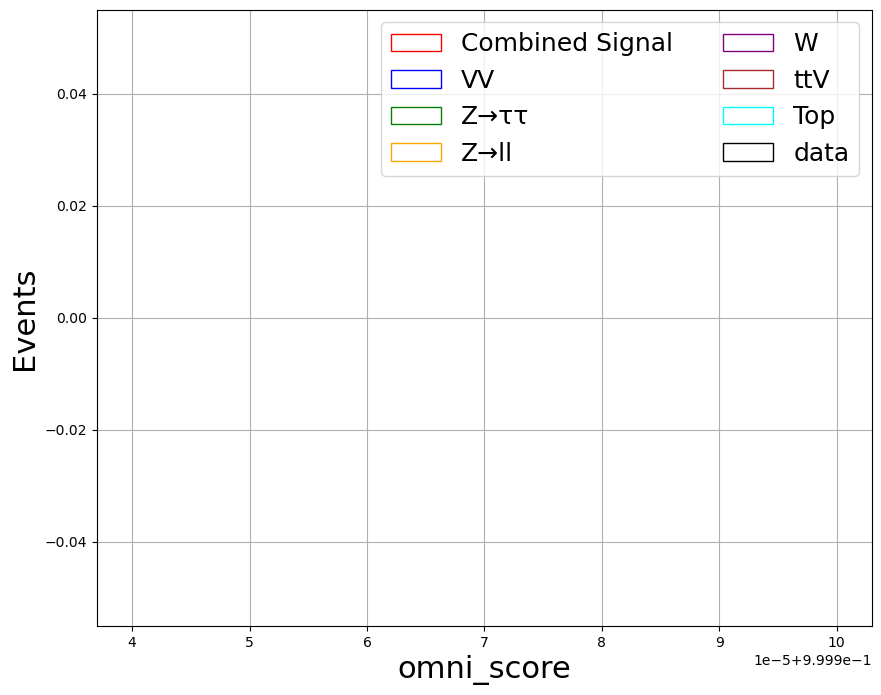

In [37]:
# Setup parameters
plt.figure(figsize=(10, 8))
plot_int = 'omni_score'
plt_bins = np.linspace(0.99994, 1, 50)

# Signal processes
signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
combined_signal = np.concatenate([process[plot_int] for process in signal_processes])

# Plot signal
plt.hist(combined_signal, bins=plt_bins, histtype='step', 
         label='Combined Signal', color='red', density=True)

# Background samples with labels and colors
backgrounds = {
    'VV': (vv_plot, 'blue'),
    'Z→ττ': (ztt_plot, 'green'),
    'Z→ll': (zll_plot, 'orange'),
    'W': (w_plot, 'purple'),
    'ttV': (ttv_plot, 'brown'),
    'Top': (top_plot, 'cyan'),
    "data": (data_plot, 'black')
}

# Plot each background
for name, (bkg_process, color) in backgrounds.items():
    plt.hist(bkg_process[plot_int], bins=plt_bins, histtype='step',
             label=name, color=color, density=True)

plt.legend(fontsize=18, ncol=2)
plt.grid(True)
plt.xlabel(plot_int, fontsize=22)
plt.ylabel('Events', fontsize=22)
plt.show()

In [30]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    606700
1     10832
Name: count, dtype: int64

In [31]:
print(df.loc[df['combined_weights'] < 0, 'combined_weights'])
print(df.loc[df['fake_factor'] < 0, 'fake_factor'])

Series([], Name: combined_weights, dtype: float64)
Series([], Name: fake_factor, dtype: float64)


In [32]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [33]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 205952 205778 205802 0 0
Signal Split: 3584 3589 3659 0 0
Background Split: 202368 202189 202143 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'met_centrality', 'event_number', 'fake_factor',
       'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 'omni_score',
       'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
       'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead',
       'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
       'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt',
       'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
       'delta_phi_met_ditau', 'ids'],
      dtype='object')


len X_train: 411580
len X_test: 205952
signal scaling factor:  55.78532008830022
len X_train: 411754
len X_test: 205778
signal scaling factor:  55.8485434212343
len X_train: 411730
len X_test: 205802
signal scaling factor:  56.39997211766346


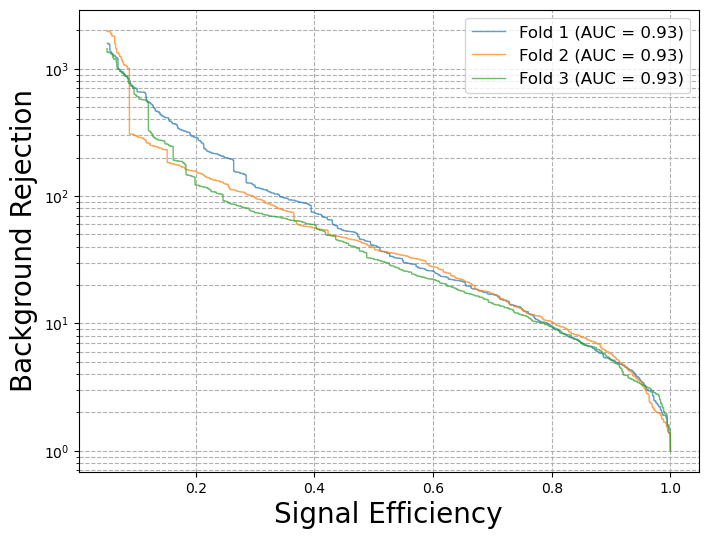

In [34]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []

bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'met': 'f5',
    'met_sig': 'f6',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    training_weight = ff_train*evnt_w_train
    val_weights = ff_test*evnt_w_test

    # training_weight = evnt_w_train
    # val_weights = evnt_w_test

    # training_weight = np.ones(len(y_train))
    # val_weights = np.ones(len(y_test))

    # training_weight = training_weight / np.mean(training_weight)
    # val_weights = val_weights / np.mean(val_weights)

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }

    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=training_weight)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    # df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
    fpr = fpr[tpr > 0.05]
    tpr = tpr[tpr > 0.05]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



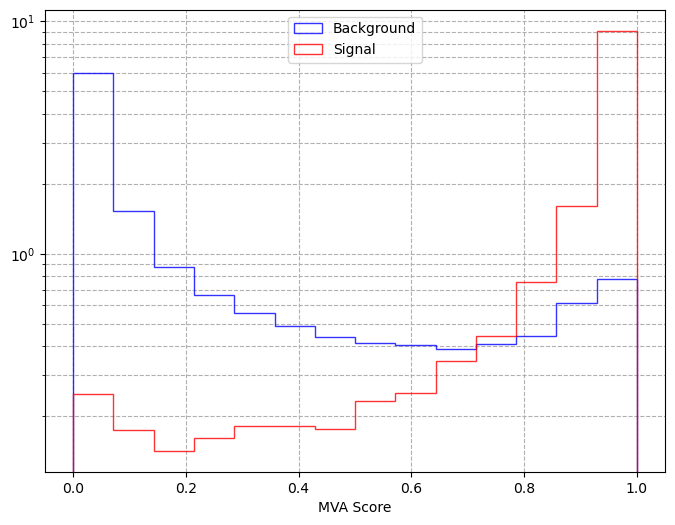

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

In [38]:
sig_hist = plt_to_root_hist_w(signal_scores, 15, 0., 1., None, False)
bkg_hist = plt_to_root_hist_w(background_scores, 15, 0., 1., None, False)
sig_hist.Scale(1/sig_hist.Integral())
bkg_hist.Scale(1/bkg_hist.Integral())
significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False)

1.559864599393662

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
